# Projet 3 (LU3IN005) : Chaines de Markov et épidémiologie :
# Propagation d’une épidémie dans une population

### <u>Groupe 6 :</u>
<pr>Samy (Adem) YAZID<br>Numéro étudiant : $3811684$<br><br>Margaux MARSELOO<br>Numéro étudiant : $28630611$</pr> 

### <u>**Consignes :**</u>
<pr>

L’objectif de ce projet est de manipuler des chaînes de Markov pour étudier la propagation d’une épidémie dans une population.<br>
Notre rendu est un notebook contenant les codes commentés et les résultats interprétés.<br>
Les packages <em>numpy</em>, <em>random</em> et <em>matplotlib</em> sont utilisés.<br>
Nous allons étudier des populations constituées de $3$ types d’individus.<br>
Chaque individu est dans un des $3$ états suivant : sain $S$, infecté $I$ ou guéri $R$.
</pr>

In [3]:
%reset -f

import numpy as np
import math
import matplotlib.pyplot as plt
import random as rd
import os
from IPython.display import Image

def rec_extract_values(iterable, dico):
    """
    Paramètres:
    iterable : any
        Iterable (ou non) dont on veut extraire les valeurs dans un dictionnaire
    dico : dict
        Dictionnaire qui stockera les valeurs extraites
        
    Retourne:
    None

    Description:
    Fonction permettant d'extraire toutes les valeurs de iterable en les stockant
    dans dico, et qui compte toutes les fois où chaque valeur est apparue.
    (Dans cette fonction les strings sont considérés comme non-iterable, donc
    seront compté comme une valeur quelconque)
    
    Exemple:
    dico : {}
    rec_extract_values([1, 3, [3, 7]])
    dico : {1:1, 3:2, 7:1}
    """
    if type(iterable) in [type([]), type(np.matrix([])), type(np.array([]))]:
        for l in iterable:
            rec_extract_values(l, dico)
        return dico
    else:
        if iterable not in dico:
            dico[iterable] = 1
        else:
            dico[iterable] += 1
            
def rec_sum_values(iterable):
    """
    Paramètres:
    iterable : any iterable type of (int or float)
        Iterable dont on veut sommer les valeurs
        
    Retourne:
    somme : int or float
        Somme des valeurs de iterable
    
    Description:
    Fonction permettant de retourner la somme de toutes les valeurs de iterable.
    
    Exemple:
    rec_sum_values([1, 3, [3, 7.5]]) : 14.5
    """
    if type(iterable) in [type([]), type(np.matrix([])), type(np.array([]))]:
        somme = 0
        for l in iterable:
            somme += rec_sum_values(l)
        return somme
    else:
        return iterable
    
def dict_zero(dico):
    """
    Paramètres:
    dico : dict
        Dictionnaire dont on veut mettre toutes ses valeurs à 0
        
    Retourne:
    None
    
    Description:
    Fonction permettant pour un dictionnaire de conserver ses clés tout en fixant leur valeur à 0.
    
    Exemple:
    dico : {1:1, 3:2, 7:1}
    dict_zero(dico)
    dico : {1:0, 3:0, 7:0}
    """
    for key in dico:
        dico[key] = 0

## I) <u>Apprentissage des paramètres d’un modèle à partir de données</u>

<pr>
    
Dans notre modèle, nous allons considérer qu’à chaque temps :
- Chaque individu sain peut rester sain ou devenir infecté
- Chaque individu infecté peut rester infecté ou devenir guéri
- Chaque individu guéri reste guéri
et que la probabilité de passer d’un état à l’autre ne dépend que de l’état précédent.

Nous disposons d’une séquence d’observations et nous souhaitons apprendre les paramètres de la
chaîne de Markov permettant de modéliser le processus sous-jacent qui a généré la séquence.<br>
Nous avons suivi un individu pendant $10$ jours, afin de déterminer a chaque temps dans quel état se trouvait l’individu.<br>
Nous avons obtenu la séquence d’observation suivante : $S, S, S, I, I ,I ,I , I, I, R$.
</pr>


<pr><u>**Question 1:**</u> À partir de cette séquence d’observation, estimez de les probabilités de transition entre les états et dresser la matrice de probabilité de transitions.</pr>


Matrice de transition du modèle :
$
\begin{pmatrix}
  &   S &   I &   R \\
S & 2/3 & 1/3 &   0 \\
I &   0 & 5/6 & 1/6 \\
R &   0 &   0 &   1 \\
\end{pmatrix}
$

In [4]:
matrice_transition = np.array([[2/3, 1/3,   0], 
                               [  0, 5/6, 1/6], 
                               [  0,   0,   1]])

<pr>
Nous avons ensuite suivi une population de $5000$ individus, pendant $200$ jours.<br>
Pour lire les données, nous avons utiliser <code>np.loadtxt("data_exo_2022.txt")</code>.<br>
Les individus sains sont notés $0$, les infectés $1$ et les guéris $2$.

<u>**Question 2:**</u><br>
    
1) Lire des données
    
</pr>

In [5]:
data = np.loadtxt("data_exo_2022.txt")

<pr>
    
2) Estimez les probabilités de transition entre les états et dressez la matrice de probabilité de transitions
(indice pour vérifier vos résultats : la première ligne de la matrice est $[0.9308, 0.0691, 0.]$).

</pr>

In [6]:
def analyse_seq(sequence, nb_etats=-1):
    sequence = sequence.astype(int)
    
    if nb_etats == -1:
        card = {elem : 0 for elem in set(sequence)}
        nb_etats = len(card)
        mat_transition_etats = np.zeros((nb_etats, nb_etats))
    else:
        mat_transition_etats = np.zeros((nb_etats, nb_etats))
    
    #on détermine la fréquence
    for etat in range(1, len(sequence)):
        mat_transition_etats[sequence[etat-1]][sequence[etat]] += 1
    mat_transition_etats[sequence[etat]][sequence[etat]] += 1
        
    return mat_transition_etats  

def matrice_proba_transition_liste(liste_sequence):
    card = {}
    rec_extract_values(liste_sequence, card)
    matrice_finale = np.zeros((len(card), len(card)))
    
    for seq in liste_sequence:
        matrice_finale += analyse_seq(seq, len(card))
    print("\nMatrice des fréquences :")
    print(matrice_finale)
    print("\n")
    print("card[0] = ",card[0])
    for i in range(len(matrice_finale)):
        for j in range(len(matrice_finale[0])):
            matrice_finale[i][j] /= card[i]
            
    return matrice_finale

print("Matrice de transition de l'exemple:\n")
print(matrice_proba_transition_liste([np.array([0., 0., 0., 1., 1., 1., 1., 1., 1., 2.])]))
print("\nMatrice de transition des 5000 individus:\n")
print(matrice_proba_transition_liste(data))

Matrice de transition de l'exemple:


Matrice des fréquences :
[[2. 1. 0.]
 [0. 5. 1.]
 [0. 0. 1.]]


card[0] =  3
[[0.66666667 0.33333333 0.        ]
 [0.         0.83333333 0.16666667]
 [0.         0.         1.        ]]

Matrice de transition des 5000 individus:


Matrice des fréquences :
[[274606.  20308.      0.]
 [     0. 274803.  18953.]
 [ 16630.      0. 394700.]]


card[0] =  294914
[[0.93113925 0.06886075 0.        ]
 [0.         0.93548047 0.06451953]
 [0.04042983 0.         0.95957017]]


Matrice de fréquence finale:
$
\begin{pmatrix}
  &   S &   I &   R \\
S & 274506 & 20408 &   0 \\
I &   0 & ? & ? \\
R &   0 &   0 &  0 \\
\end{pmatrix}
$

## II) <u>Description du premier modèle</u>
<pr>La probabilité pour un individu d’être dans un de ces $3$ états au temps $t$, ne dépend que l’état dans
lequel il est au temps $t − 1$.<br>
Un individu dans l’état sain a une probabilité de $0.92$ de rester sain et une probabilité de $0.08$ de
devenir infecté. Si l’individu est infecté, il peut le rester avec une probabilité de $0.93$ et être guéri avec
une probabilité de $0.07$. S’il est dans l’état guéri, il reste dans cet état avec une probabilité de $1$.

<u>**Question 1:**</u> À partir du graphe de transition, créez la matrice de transition $A$, la matrice contenant les probabilités de transition entre les différents états. Créez une fonction permettant de vérifier qu’une matrice est stochastique.
</pr>

Matrice de transition du premier modèle :<br>
$A = 
\begin{pmatrix}
  &    S &    I &    R \\
S & 0.92 & 0.08 &    0 \\
I &    0 & 0.93 & 0.07 \\
R &    0 &    0 &    1 \\
\end{pmatrix}
$

In [7]:
matrice_transition_modele1 = np.array([[0.92, 0.08,    0], 
                                       [   0, 0.93, 0.07], 
                                       [   0,    0,    1]])

def est_stochastique(matrice):
    epsilon = 0.00001
    for ligne in matrice:
        if len(list(filter(lambda x: (x < 0), ligne))) != 0 :
               return False
        if abs(rec_sum_values(ligne) - 1) >= epsilon:
            return False
    return True

print("La matrice de transition de la partie I) est-elle stochastique ? :", est_stochastique(matrice_transition))

print("La matrice de transition de la partie II) est-elle stochastique ? :", est_stochastique(matrice_transition_modele1))

La matrice de transition de la partie I) est-elle stochastique ? : True
La matrice de transition de la partie II) est-elle stochastique ? : True


<pr>
Au temps $t = 0$, un individu a une probabilité de $0.9$ d’être sain et $0.1$ d’être infecté.

<u>**Question 2:**</u> Créez $π_0$ la distribution de probabilité initiale.
</pr>

$
π_0 = 
\begin{pmatrix}
   S &    I &    R \\
0.90 & 0.10 &    0 \\
\end{pmatrix}
$

In [8]:
pi_0 = np.array([0.90,
                 0.10,
                 0.00])

<pr>
Nous allons étudier l’évolution du nombre d’individu sains, infectés et guéris au cours du temps.
Dans un premier temps nous étudierons la distribution théorique, puis la distribution observée sur des simulations.
</pr>

### <u>Distribution $π_t$<u>

<pr><u>**Question 1:**</u> En utilisant $π_0$ et $A$, donnez la probabilité pour un individu d’être sain, infecté ou guéri au temps $t = 1$ (faire d’abord le calcul à la main).
</pr>


$
π_1 = π_0 * A =
\begin{pmatrix}
   S &    I &    R \\
0.90*0.92 + 0*0 & 0.90*0.08 + 0.10*0.93 &    0.10*0.07 + 0*1 \\
\end{pmatrix}
=
\begin{pmatrix}
   S &    I &    R \\
0.828 & 0.165 & 0.007\\
\end{pmatrix}
$

In [9]:
pi_1 = np.dot(pi_0, matrice_transition_modele1) 

print("pi_1 =", pi_1)

pi_1 = [0.828 0.165 0.007]


<pr><u>**Question 2:**</u> Donnez la probabilité pour un individu d’être sain, infecté ou guéri au temps $t = 2$ (faire d’abord le calcul à la main).
</pr>

$
π_2 = π_1 * A =
\begin{pmatrix}
   S &    I &    R \\
0.828*0.92 + 0.007*0   &   0.828*0.08 + 0.165*0.93   &   0.165*0.07 + 0.007*1 \\
\end{pmatrix}
=
\begin{pmatrix}
   S &    I &    R \\
0.76176 & 0.21969 & 0.01855\\
\end{pmatrix}
$

In [10]:
pi_2 = np.dot(pi_1, matrice_transition_modele1) 

print("pi_2 =", pi_2)


pi_2 = [0.76176 0.21969 0.01855]


<pr><u>**Question 3:**</u> De même pour chaque temps $t$ entre $1$ et $200$, calculez la distribution théorique des effectifs dans chaque état (<em>Rappel:</em> $π_{t+1} = π_t . A$ ).
</pr>

In [11]:
def liste_pi(pi_0, A, n):
    l_pi = [pi_0]
    for i in range(1, n+1):
        l_pi.append(np.dot(l_pi[i-1], A))
    return l_pi

liste_pi_i = np.array(liste_pi(pi_0, matrice_transition_modele1, 200))
print("Liste des pi_i pour i entre 0 et 200 :")
print(liste_pi_i)

Liste des pi_i pour i entre 0 et 200 :
[[9.00000000e-01 1.00000000e-01 0.00000000e+00]
 [8.28000000e-01 1.65000000e-01 7.00000000e-03]
 [7.61760000e-01 2.19690000e-01 1.85500000e-02]
 [7.00819200e-01 2.65252500e-01 3.39283000e-02]
 [6.44753664e-01 3.02750361e-01 5.24959750e-02]
 [5.93173371e-01 3.33138129e-01 7.36885003e-02]
 [5.45719501e-01 3.57272330e-01 9.70081693e-02]
 [5.02061941e-01 3.75920827e-01 1.22017232e-01]
 [4.61896986e-01 3.89771324e-01 1.48331690e-01]
 [4.24945227e-01 3.99439090e-01 1.75615683e-01]
 [3.90949609e-01 4.05473972e-01 2.03576419e-01]
 [3.59673640e-01 4.08366763e-01 2.31959597e-01]
 [3.30899749e-01 4.08554980e-01 2.60545271e-01]
 [3.04427769e-01 4.06428112e-01 2.89144119e-01]
 [2.80073547e-01 4.02332365e-01 3.17594087e-01]
 [2.57667664e-01 3.96574984e-01 3.45757353e-01]
 [2.37054251e-01 3.89428148e-01 3.73517602e-01]
 [2.18089911e-01 3.81132518e-01 4.00777572e-01]
 [2.00642718e-01 3.71900434e-01 4.27456848e-01]
 [1.84591300e-01 3.61918821e-01 4.53489879e-01]
 

<pr><u>**Question 4:**</u> Représentez graphiquement la probabilité d’être dans chaque état en fonction du temps. (+ décrivez un peu ce que vous observez).
</pr>

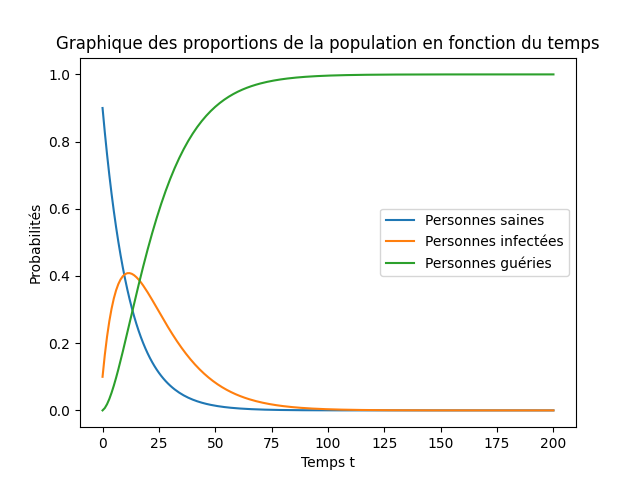

In [12]:
def affiche_graphe_multi(liste_pi_i, xlabel="Temps t", ylabel="Probabilités", nom_fig="Graphe", loc_legend='center right'):
    #on crée les ordonnées
    liste_sains = []
    liste_infectes = []
    liste_gueris = []
    for pi in liste_pi_i:
        liste_sains.append(pi[0])
        liste_infectes.append(pi[1])
        liste_gueris.append(pi[2])
    
    #on crée les abscisses
    abscisses = [i for i in range(len(liste_pi_i))]
    
    #on plot le graphe comme une courbe
    plt.plot(abscisses, liste_sains)
    plt.plot(abscisses, liste_infectes)
    plt.plot(abscisses, liste_gueris)
    
    #on légende le graphe
    plt.legend(["Personnes saines", "Personnes infectées", "Personnes guéries"], loc=loc_legend)
    
    #on nomme l'axe des abscisses
    plt.xlabel(xlabel)
    #on nomme l'axe des ordonnées
    plt.ylabel(ylabel)
    
    #on paramètre l'échelle des abscisses suivant l'option x_scale
    plt.xscale("linear")
    #on paramètre l'échelle des ordonnées comme linéaire
    plt.yscale("linear")
    
    #on donne un titre au graphique
    plt.title("Graphique des proportions de la population en fonction du temps")
    
    #on sauvegarde le graphe
    if os.path.isfile(nom_fig):
        os.remove(nom_fig)
    plt.savefig(nom_fig)
    
    #on affiche le graphe
    #plt.show()
    
    #on ferme le plot
    plt.close()
    
affiche_graphe_multi(liste_pi_i, nom_fig="Graph_Partie2.png")
Image(filename="Graph_Partie2.png")

<pr><u>**Interprétation du graphique:**</u>
    Nous remarquons qu'il n'y qu'une seule vague d'infection. Les états sains et infectés sont transients tant dit que l'état guéri est récurrent. L'état guéri est en effet un état absorbant. Nous voyons bien ici que ce modèle converge rapidement vers 
$π ^* = 
\begin{pmatrix}
   S &    I &     R \\
 0.0 &  0.0 & 1.0 \\
\end{pmatrix}
$
.<br>
</pr>

### <u>Tirage aléatoire des états</u>
<pr>Nous allons générer une séquence de taille $T$ en utilisant cette chaîne de Markov. Pour générer une séquence aléatoire, nous choisissons un état initial au hasard (en utilisant $π_0$) ; puis nous choisissons les états suivants en suivant les probabilités de transition <em>(= la matrice de transition $A$).</em>
Nous prenons $T=150$.
</pr>

In [13]:
def genere_sequence(pi_0, A, n):
    p = rd.random()
    sequence = []
    
    #on choisit l'état initial au hasard
    for i in range(len(pi_0)):
        if p < sum(pi_0[:i+1]):
            sequence.append(i)
            break

    #on choisit les états suivants
    for i in range(1, n):
        p = rd.random()
        for j in range(len(A)):
            if p < sum(A[sequence[-1]][:j+1]):
                sequence.append(j)
                break
    return np.array(sequence)

print("L'une des séquences aléatoires de taille 150 suivant cette chaîne de Markov est :\n")
print(genere_sequence(pi_0, matrice_transition_modele1, 150))

L'une des séquences aléatoires de taille 150 suivant cette chaîne de Markov est :

[0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


### <u>Modélisation d’une population</u>
<pr>Nous avons généré une séquence d’état pour un individu. Maintenant nous allons générer un ensemble de séquences pour une population de 200 individus.

<u>**Question 1:**</u> À chaque temps $t$, nous comptons le nombre d’individus sains, infectés et guéris dans la population et affichons l’évolution du nombre d’individus dans les trois états en fonction du temps.
</pr>

In [14]:
def genere_liste_sequence(pi_0, A, nb_individu, temps):
    liste_sequence = []
    for i in range(nb_individu):
        liste_sequence.append(genere_sequence(pi_0, A, temps))
    return np.array(liste_sequence)

def comptage_liste_sequence(liste_sequence, nb_etats=3):
    liste_comptage = []
    for jour in range(len(liste_sequence[0])):
        comptage = [0 for i in range(nb_etats)]
        for seq in liste_sequence:
            comptage[seq[jour]] += 1
        liste_comptage.append(comptage)
    return np.array(liste_comptage)

liste_sequence = genere_liste_sequence(pi_0, matrice_transition_modele1, 200, 150)
liste_comptage = comptage_liste_sequence(liste_sequence)

print("La liste de 200 séquences est :\n")
print(liste_sequence)

print("\n\nLa liste de 200 séquences compte cet effectif au cours du temps:\n")
print(liste_comptage)

La liste de 200 séquences est :

[[0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 ...
 [0 0 0 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [0 0 1 ... 2 2 2]]


La liste de 200 séquences compte cet effectif au cours du temps:

[[186  14   0]
 [176  24   0]
 [160  40   0]
 [150  47   3]
 [134  59   7]
 [122  67  11]
 [112  72  16]
 [102  78  20]
 [ 97  77  26]
 [ 92  78  30]
 [ 86  78  36]
 [ 83  75  42]
 [ 75  81  44]
 [ 68  84  48]
 [ 63  85  52]
 [ 57  83  60]
 [ 51  85  64]
 [ 48  83  69]
 [ 44  80  76]
 [ 40  78  82]
 [ 36  78  86]
 [ 34  72  94]
 [ 29  72  99]
 [ 28  69 103]
 [ 26  67 107]
 [ 25  64 111]
 [ 21  66 113]
 [ 20  61 119]
 [ 19  61 120]
 [ 18  59 123]
 [ 16  59 125]
 [ 14  60 126]
 [ 14  56 130]
 [ 13  55 132]
 [ 12  50 138]
 [ 12  46 142]
 [ 11  46 143]
 [ 10  44 146]
 [ 10  38 152]
 [ 10  36 154]
 [ 10  34 156]
 [ 10  33 157]
 [  8  32 160]
 [  8  30 162]
 [  6  28 166]
 [  6  28 166]
 [  6  25 169]
 [  5  21 174]
 [  4  21 175]
 [  4  20 176]
 [  3  21 176]
 [  3  20 177]

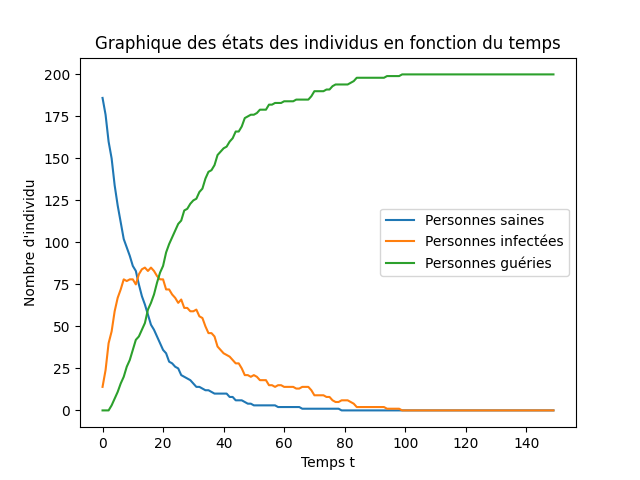

In [15]:
def affiche_graphe_nb_individu(liste_comptage, nom_fig="Graphe"):
    #on crée les ordonnées
    liste_sains = []
    liste_infectes = []
    liste_gueris = []
    
    for occurence in liste_comptage:
        liste_sains.append(occurence[0])
        liste_infectes.append(occurence[1])
        liste_gueris.append(occurence[2])
    
    #on crée les abscisses
    abscisses = [i for i in range(len(liste_comptage))]
    
    #on plot le graphe comme une courbe
    plt.plot(abscisses, liste_sains)
    plt.plot(abscisses, liste_infectes)
    plt.plot(abscisses, liste_gueris)
    
    #on légende le graphe
    plt.legend(["Personnes saines", "Personnes infectées", "Personnes guéries"], loc='center right')
    
    #on nomme l'axe des abscisses
    plt.xlabel("Temps t")
    #on nomme l'axe des ordonnées
    plt.ylabel("Nombre d'individu")
    
    #on paramètre l'échelle des abscisses suivant l'option x_scale
    plt.xscale("linear")
    #on paramètre l'échelle des ordonnées comme linéaire
    plt.yscale("linear")
    
    #on donne un titre au graphique
    plt.title("Graphique des états des individus en fonction du temps")
    
    #on sauvegarde le graphe
    if os.path.isfile(nom_fig):
        os.remove(nom_fig)
    plt.savefig(nom_fig)
    
    #on affiche le graphe
    #plt.show()
    
    #on ferme le plot
    plt.close()
    
affiche_graphe_nb_individu(liste_comptage, nom_fig="Graph_Partie2_2.png")
Image(filename="Graph_Partie2_2.png")

<pr><u>**Question 2:**</u> Affichez le pourcentage d’individus sains infectés et guéris en fonction du temps.
</pr>

In [16]:
def pourcentage_liste_sequence(liste_sequence):
    liste_pourcentage = [[((cpt/sum(l_cpt))*100) for cpt in l_cpt] for l_cpt in comptage_liste_sequence(liste_sequence)]
    return np.array(liste_pourcentage)

liste_pourcentage = pourcentage_liste_sequence(liste_sequence)
print("\n\nLa liste de 200 séquences compte ces pourcentage d'individus sains/infectés/guéris au cours du temps:")
print(liste_pourcentage)



La liste de 200 séquences compte ces pourcentage d'individus sains/infectés/guéris au cours du temps:
[[ 93.    7.    0. ]
 [ 88.   12.    0. ]
 [ 80.   20.    0. ]
 [ 75.   23.5   1.5]
 [ 67.   29.5   3.5]
 [ 61.   33.5   5.5]
 [ 56.   36.    8. ]
 [ 51.   39.   10. ]
 [ 48.5  38.5  13. ]
 [ 46.   39.   15. ]
 [ 43.   39.   18. ]
 [ 41.5  37.5  21. ]
 [ 37.5  40.5  22. ]
 [ 34.   42.   24. ]
 [ 31.5  42.5  26. ]
 [ 28.5  41.5  30. ]
 [ 25.5  42.5  32. ]
 [ 24.   41.5  34.5]
 [ 22.   40.   38. ]
 [ 20.   39.   41. ]
 [ 18.   39.   43. ]
 [ 17.   36.   47. ]
 [ 14.5  36.   49.5]
 [ 14.   34.5  51.5]
 [ 13.   33.5  53.5]
 [ 12.5  32.   55.5]
 [ 10.5  33.   56.5]
 [ 10.   30.5  59.5]
 [  9.5  30.5  60. ]
 [  9.   29.5  61.5]
 [  8.   29.5  62.5]
 [  7.   30.   63. ]
 [  7.   28.   65. ]
 [  6.5  27.5  66. ]
 [  6.   25.   69. ]
 [  6.   23.   71. ]
 [  5.5  23.   71.5]
 [  5.   22.   73. ]
 [  5.   19.   76. ]
 [  5.   18.   77. ]
 [  5.   17.   78. ]
 [  5.   16.5  78.5]
 [  4.   16.  

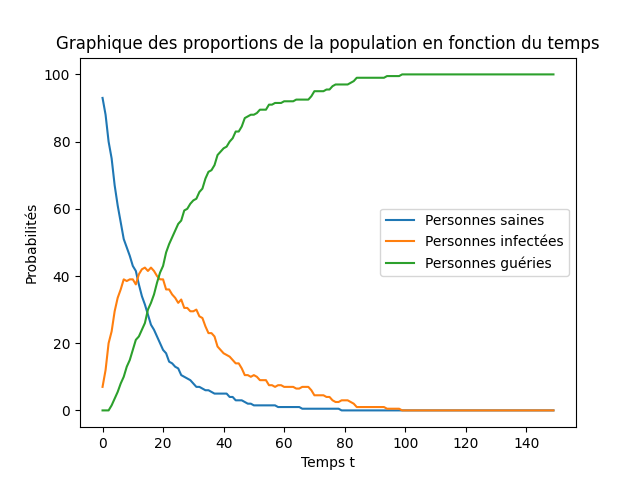

In [17]:
affiche_graphe_multi(liste_pourcentage, nom_fig="Graph_Partie2_3.png")
Image(filename="Graph_Partie2_3.png")

<pr><u>**Question 3:**</u> Quand $t$ est grand, quelle est la proportion d’individus sains, infectés et guéris ?
</pr>

<pr>
Lorsque $t$ est grand, la répartition de la population est la suivante :  $π^*_1$ = 
$ 
\begin{pmatrix}
   S &    I &     R \\
 0\% &  0\% & 100\% \\
\end{pmatrix}
$
.<br>
</pr>

<pr><u>**Question 4:**</u> Nous avons refait les questions précédentes avec des populations de tailles différentes, $5$ individus et $5000$ individus par exemple.
</pr>

In [18]:
#Pour 5 individus
liste_sequence = genere_liste_sequence(pi_0, matrice_transition_modele1, 5, 150)
liste_comptage = comptage_liste_sequence(liste_sequence)

print("La liste de 5 séquences est :\n")
print(liste_sequence)

print("\n\nLa liste de 5 séquences compte cet effectif au cours du temps:\n")
print(liste_comptage)

La liste de 5 séquences est :

[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 

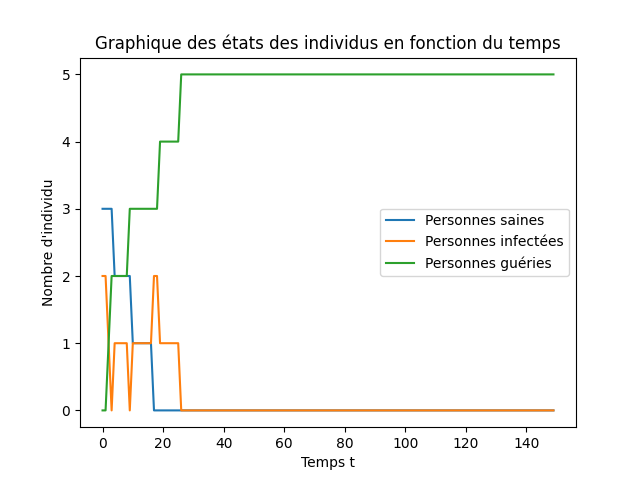

In [19]:
affiche_graphe_nb_individu(liste_comptage, nom_fig="Graph_Partie2_4.png")
Image(filename="Graph_Partie2_4.png")

In [20]:
#Pour 5000 individus
liste_sequence = genere_liste_sequence(pi_0, matrice_transition_modele1, 5000, 150)
liste_comptage = comptage_liste_sequence(liste_sequence)

print("La liste de 5000 séquences est :\n")
print(liste_sequence)

print("\n\nLa liste de 5000 séquences compte cet effectif au cours du temps:\n")
print(liste_comptage)

La liste de 5000 séquences est :

[[0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 ...
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]]


La liste de 5000 séquences compte cet effectif au cours du temps:

[[4531  469    0]
 [4188  775   37]
 [3833 1087   80]
 [3476 1357  167]
 [3189 1546  265]
 [2941 1679  380]
 [2711 1796  493]
 [2495 1900  605]
 [2304 1948  748]
 [2126 2001  873]
 [1957 2013 1030]
 [1822 1992 1186]
 [1672 2008 1320]
 [1537 1997 1466]
 [1425 1974 1601]
 [1327 1928 1745]
 [1218 1901 1881]
 [1126 1843 2031]
 [1048 1793 2159]
 [ 971 1751 2278]
 [ 902 1703 2395]
 [ 825 1673 2502]
 [ 769 1613 2618]
 [ 710 1558 2732]
 [ 662 1498 2840]
 [ 600 1447 2953]
 [ 544 1405 3051]
 [ 505 1349 3146]
 [ 466 1298 3236]
 [ 427 1258 3315]
 [ 380 1197 3423]
 [ 346 1153 3501]
 [ 323 1108 3569]
 [ 300 1047 3653]
 [ 280  992 3728]
 [ 268  923 3809]
 [ 245  881 3874]
 [ 224  837 3939]
 [ 212  789 3999]
 [ 197  750 4053]
 [ 184  709 4107]
 [ 168  672 4160]
 [ 160  636 4204]
 [ 

In [21]:
liste_pourcentage = pourcentage_liste_sequence(liste_sequence)
print("\n\nLa liste de 5000 séquences compte ces pourcentage d'individus sains/infectés/guéris au cours du temps:")
print(liste_pourcentage)



La liste de 5000 séquences compte ces pourcentage d'individus sains/infectés/guéris au cours du temps:
[[9.062e+01 9.380e+00 0.000e+00]
 [8.376e+01 1.550e+01 7.400e-01]
 [7.666e+01 2.174e+01 1.600e+00]
 [6.952e+01 2.714e+01 3.340e+00]
 [6.378e+01 3.092e+01 5.300e+00]
 [5.882e+01 3.358e+01 7.600e+00]
 [5.422e+01 3.592e+01 9.860e+00]
 [4.990e+01 3.800e+01 1.210e+01]
 [4.608e+01 3.896e+01 1.496e+01]
 [4.252e+01 4.002e+01 1.746e+01]
 [3.914e+01 4.026e+01 2.060e+01]
 [3.644e+01 3.984e+01 2.372e+01]
 [3.344e+01 4.016e+01 2.640e+01]
 [3.074e+01 3.994e+01 2.932e+01]
 [2.850e+01 3.948e+01 3.202e+01]
 [2.654e+01 3.856e+01 3.490e+01]
 [2.436e+01 3.802e+01 3.762e+01]
 [2.252e+01 3.686e+01 4.062e+01]
 [2.096e+01 3.586e+01 4.318e+01]
 [1.942e+01 3.502e+01 4.556e+01]
 [1.804e+01 3.406e+01 4.790e+01]
 [1.650e+01 3.346e+01 5.004e+01]
 [1.538e+01 3.226e+01 5.236e+01]
 [1.420e+01 3.116e+01 5.464e+01]
 [1.324e+01 2.996e+01 5.680e+01]
 [1.200e+01 2.894e+01 5.906e+01]
 [1.088e+01 2.810e+01 6.102e+01]
 [1.

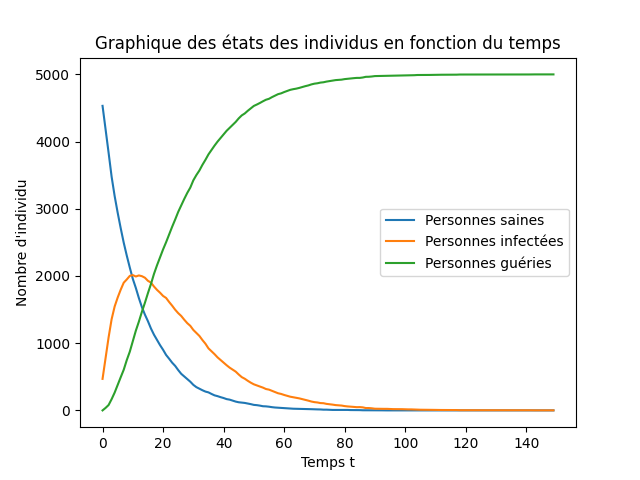

In [22]:
affiche_graphe_nb_individu(liste_comptage, nom_fig="Graph_Partie2_5.png")
Image(filename="Graph_Partie2_5.png")

### <u>Longueur de l’infection</u>
<pr>

<u>**Question 1:**</u> À partir des simulations, nous estimons la longueur moyenne d’une séquence de $I$.
</pr>

In [23]:
def longueur_moyenne(liste_sequence, categorie):
    moy = 0
    for seq in liste_sequence:
        for etat in seq:
            if etat == categorie:
                moy += 1
    return moy/len(liste_sequence)

longueur_moyenne_infectes = longueur_moyenne(liste_sequence, 1)

print("La longueur moyenne d'une séquence de I est de", longueur_moyenne_infectes, "jours")

La longueur moyenne d'une séquence de I est de 14.124 jours


<u>**Question 2:**</u> Affichons la distribution observée de la longueur d’infection à l'aide d'un histogramme.
</pr>

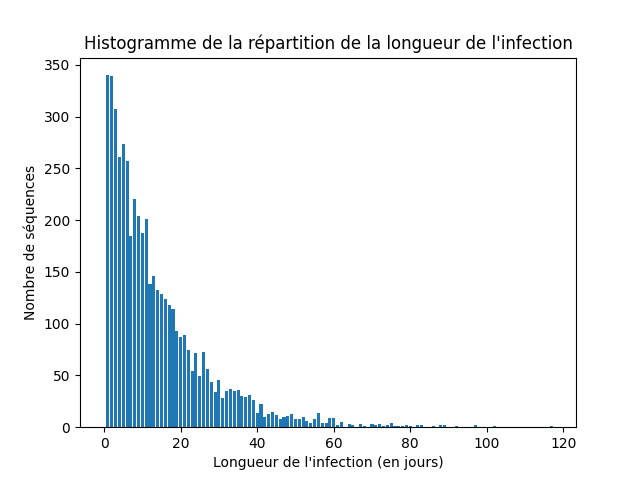

In [24]:
def repartition_longueur_moyenne(liste_sequence, categorie):
    dico_repart = {}
    for seq in liste_sequence:
        cpt = 0
        for etat in seq:
            if etat == categorie:
                cpt += 1
        if cpt in dico_repart:
            dico_repart[cpt] += 1
        else:
            dico_repart[cpt] = 1
    for i in range(max(dico_repart)):
        if i not in dico_repart:
            dico_repart[i] = 0
    
    return dico_repart

def affiche_graphe_repartition(dico_repart, categorie, nom_fig="Histo"):
    #on crée les abscisses
    abscisses = [key for key in dico_repart]
    abscisses.sort()
    
    #on crée les ordonnées
    ordonnees = [dico_repart[key] for key in abscisses]
    
    #on plot l'histogramme
    plt.bar(abscisses, ordonnees)
    
    #on nomme l'axe des abscisses
    if categorie == 1:
        plt.xlabel("Longueur de l'infection (en jours)")
    elif categorie == 2:
        plt.xlabel("Longueur de l'immunité (en jours)")
    #on nomme l'axe des ordonnées
    plt.ylabel("Nombre de séquences")
    
    #on paramètre l'échelle des abscisses suivant l'option x_scale
    plt.xscale("linear")
    #on paramètre l'échelle des ordonnées comme linéaire
    plt.yscale("linear")
    
    #on donne un titre au graphique
    if categorie == 1:
        plt.title("Histogramme de la répartition de la longueur de l'infection")
    elif categorie == 2:
        plt.title("Histogramme de la répartition de la longueur de l'immunité")
       
    #on sauvegarde le graphe
    if os.path.isfile(nom_fig):
        os.remove(nom_fig)
    plt.savefig(nom_fig)
    
    #on affiche le graphe
    #plt.show()
    
    #on ferme le plot
    plt.close()

dico_repart = repartition_longueur_moyenne(liste_sequence, 1)

affiche_graphe_repartition(dico_repart, 1, nom_fig="Histo_Partie2.png")
Image(filename="Histo_Partie2.png")

<u>**Question 3:**</u> Calculez la longueur théorique d’une séquence de $I$ (vous pourrez utiliser l’espérance de la loi géométrique en justifiant).
</pr>

<pr>
Nous cherchons ici à estimer combien de temps un individu infecté reste infecté, soit le nombre de fois en moyenne où, à partir de l'état infecté, on retourne sur l'état infecté. Nous remarquons qu'à partir de l'état infecté il n'y a que deux issues possibles, l'état infecté avec une probabilité q = 0,93 et l'état guéri avec une probabilité p = 0,07. Il s'agit donc d'une épreuve de Bernouilli.    
<br>
<br>   
Nous pouvons modéliser notre problème par une loi géométrique. En effet, une loi géométrique est composée d'une suite d'épreuves de Bernoulli indépendantes, et désigne le nombre d'échecs nécessaire pour obtenir le premier succès. Ici, notre succès représente la sortie de l'état infecté, donc la transition vers l'état guéri, et les échecs sont les retours vers l'état infecté. Ainsi, en calculant l'espérance d'un loi géométrique de paramètre p = 0,07, nous aurons le nombre moyen d'échecs avant un succès et donc la longueur théorique d'une séquence d'état infecté.
</pr>

In [25]:
p = matrice_transition_modele1[1][2]
print("L'espérance de la longueur d'une séquence de I est", (1/p),
      "sachant que la probabilité de sortir de l'état infecté est", p)

L'espérance de la longueur d'une séquence de I est 14.285714285714285 sachant que la probabilité de sortir de l'état infecté est 0.07


<u>**Question 4:**</u> Comparer la longueur estimée et la longueur théorique.
</pr>

<pr>
La longueur estimée est de $14.23$ jours, tandis que la longueur théorique est de $14.29$ jours.<br>
Nous considérons donc que les deux valeurs coïncident et que la différence de $0.06$ est négligeable.
</pr>

<u>**Question 5:**</u> Affichez la distribution théorique de la longueur d’infection.
</pr>

On peut faire varier $k$ pour $P(X=k)$ avec $X$ une loi géométrique de probabilité $p = 0.07$

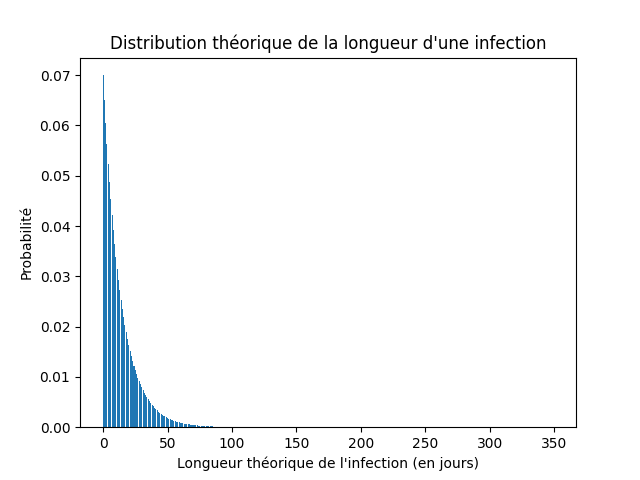

In [26]:
def loi_geometrique(p_succes, nb_echecs):    
    return p_succes * (1-p_succes)**nb_echecs

def affiche_graphe_repartition(p_succes, categorie, nom_fig="Histo"):
    #on crée les abscisses
    abscisses = [taille_seq for taille_seq in range(350)]
    
    #on crée les ordonnées
    ordonnees = [loi_geometrique(p,taille_seq) for taille_seq in range(350)]
    
    #on plot l'histogramme
    plt.bar(abscisses, ordonnees)
    
    #on nomme l'axe des abscisses
    if categorie == 1:
        plt.xlabel("Longueur théorique de l'infection (en jours)")
    elif categorie == 2:
        plt.xlabel("Longueur théorique de l'immunité (en jours)")
    #on nomme l'axe des ordonnées
    plt.ylabel("Probabilité")
    
    #on paramètre l'échelle des abscisses suivant l'option x_scale
    plt.xscale("linear")
    #on paramètre l'échelle des ordonnées comme linéaire
    plt.yscale("linear")
    
    #on donne un titre au graphique
    if categorie == 1:
        plt.title("Distribution théorique de la longueur d'une infection")
    elif categorie == 2:
        plt.title("Distribution théorique de la longueur de l'immunité")
       
    #on sauvegarde le graphe
    if os.path.isfile(nom_fig):
        os.remove(nom_fig)
    plt.savefig(nom_fig)
    
    #on affiche le graphe
    #plt.show()
    
    #on ferme le plot
    plt.close()

affiche_graphe_repartition(0.07, 1, nom_fig="Histo_Partie2_theorique.png")
Image(filename="Histo_Partie2_theorique.png")

### <u>Petites modifications autour de ce premier modèle</u>
<pr>Vous pouvez maintenant modifier le modèle pour étudier différents cas de figure, en
faisant varier certains paramètres :
</pr>

<u>**Question 1:**</u> Faire varier la taille de la population.
</pr>

In [27]:
liste_sequence_1 = genere_liste_sequence(pi_0, matrice_transition_modele1, 100, 150)
liste_pourcentage_1 = pourcentage_liste_sequence(liste_sequence_1)

liste_sequence_2 = genere_liste_sequence(pi_0, matrice_transition_modele1, 500, 150)
liste_pourcentage_2 = pourcentage_liste_sequence(liste_sequence_2)

liste_sequence_3 = genere_liste_sequence(pi_0, matrice_transition_modele1, 1000, 150)
liste_pourcentage_3 = pourcentage_liste_sequence(liste_sequence_3)

<u>Taille de la population</u> : $100$

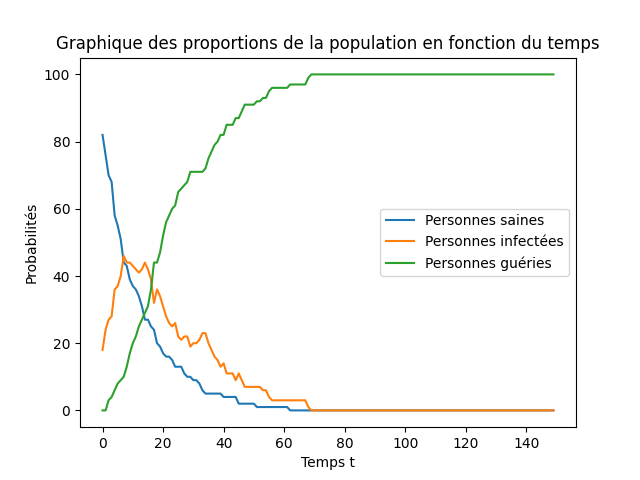

In [28]:
affiche_graphe_multi(liste_pourcentage_1, nom_fig="Graph_Partie2_6_1.png")
Image(filename="Graph_Partie2_6_1.png")

<u>Taille de la population</u> : $500$

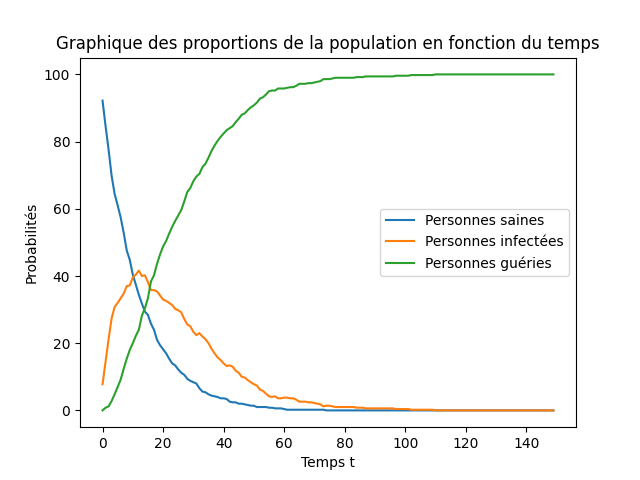

In [29]:
affiche_graphe_multi(liste_pourcentage_2, nom_fig="Graph_Partie2_6_2.png")
Image(filename="Graph_Partie2_6_2.png")

<u>Taille de la population</u> : $1000$

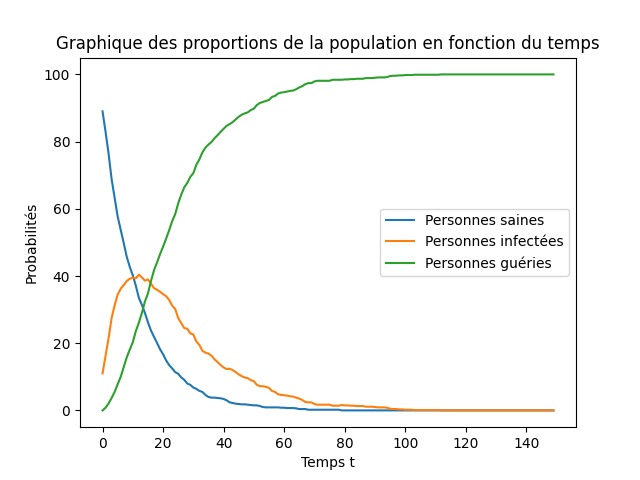

In [30]:
affiche_graphe_multi(liste_pourcentage_3, nom_fig="Graph_Partie2_6_3.png")
Image(filename="Graph_Partie2_6_3.png")

<pr>
Nous remarquons que le modèle est plutot stable mais que plus la population augmente, plus l'on tend vers les prévisions théoriques du modèle.
</pr>

<u>**Question 2:**</u> Faire varier la distribution de probabilité initiale.
</pr>

In [31]:
pi_0_2 = [0.50, 0.50, 0]
pi_0_3 = [0.10, 0.90, 0]

liste_sequence_1 = genere_liste_sequence(pi_0, matrice_transition_modele1, 1000, 150)
liste_pourcentage_1 = pourcentage_liste_sequence(liste_sequence_1)

liste_sequence_2 = genere_liste_sequence(pi_0_2, matrice_transition_modele1, 1000, 150)
liste_pourcentage_2 = pourcentage_liste_sequence(liste_sequence_2)

liste_sequence_3 = genere_liste_sequence(pi_0_3, matrice_transition_modele1, 1000, 150)
liste_pourcentage_3 = pourcentage_liste_sequence(liste_sequence_3)

$
π_0 = 
\begin{pmatrix}
   S &    I &    R \\
0.90 & 0.10 &    0 \\
\end{pmatrix}
$

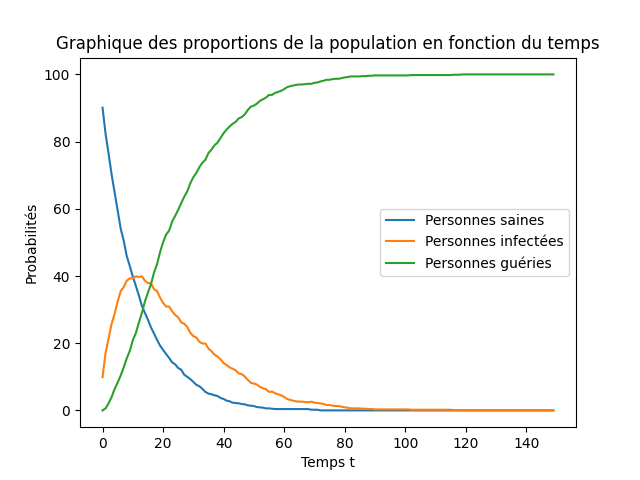

In [32]:
affiche_graphe_multi(liste_pourcentage_1, nom_fig="Graph_Partie2_7_1.png")
Image(filename="Graph_Partie2_7_1.png")

$
π_0 = 
\begin{pmatrix}
   S &    I &    R \\
0.50 & 0.50 &    0 \\
\end{pmatrix}
$

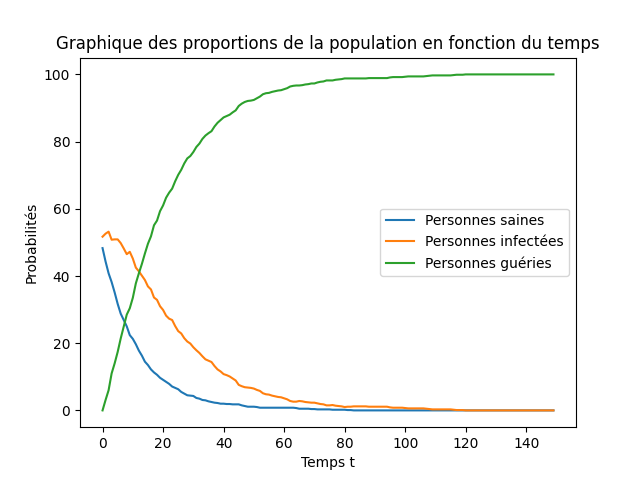

In [33]:
affiche_graphe_multi(liste_pourcentage_2, nom_fig="Graph_Partie2_7_2.png")
Image(filename="Graph_Partie2_7_2.png")

$
π_0 = 
\begin{pmatrix}
   S &    I &    R \\
0.10 & 0.90 &    0 \\
\end{pmatrix}
$

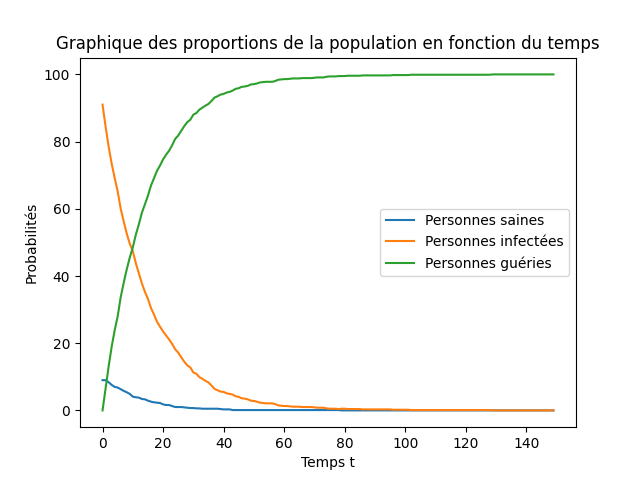

In [34]:
affiche_graphe_multi(liste_pourcentage_3, nom_fig="Graph_Partie2_7_3.png")
Image(filename="Graph_Partie2_7_3.png")

<pr>
Nous remarquons que $π_0$ n'a aucune influence sur la convergence du modèle. <br>Cependant, il permet de modifier le point de départ des 3 courbes, modifiant ainsi la forme du graphique.
</pr>

<u>**Question 3:**</u> Faire varier les probabilités de transition.
</pr>

In [35]:
matrice_transition_modele1_2 = np.array([[0.97, 0.03,    0], 
                                         [   0, 0.97, 0.03], 
                                         [   0,    0,    1]])
matrice_transition_modele1_3 = np.array([[0.60, 0.40,    0], 
                                         [   0, 0.60, 0.40], 
                                         [   0,    0,    1]])

liste_sequence_1 = genere_liste_sequence(pi_0, matrice_transition_modele1, 1000, 150)
liste_pourcentage_1 = pourcentage_liste_sequence(liste_sequence_1)

liste_sequence_2 = genere_liste_sequence(pi_0, matrice_transition_modele1_2, 1000, 150)
liste_pourcentage_2 = pourcentage_liste_sequence(liste_sequence_2)

liste_sequence_3 = genere_liste_sequence(pi_0, matrice_transition_modele1_3, 1000, 150)
liste_pourcentage_3 = pourcentage_liste_sequence(liste_sequence_3)

$A = 
\begin{pmatrix}
  &    S &    I &    R \\
S & 0.92 & 0.08 &    0 \\
I &    0 & 0.93 & 0.07 \\
R &    0 &    0 &    1 \\
\end{pmatrix}
$

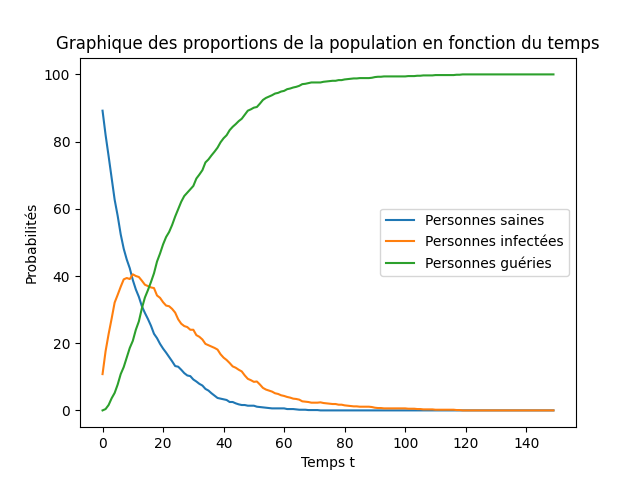

In [36]:
affiche_graphe_multi(liste_pourcentage_1, nom_fig="Graph_Partie2_8_1.png")
Image(filename="Graph_Partie2_8_1.png")

$A = 
\begin{pmatrix}
  &    S &    I &    R \\
S & 0.97 & 0.03 &    0 \\
I &    0 & 0.97 & 0.03 \\
R &    0 &    0 &    1 \\
\end{pmatrix}
$

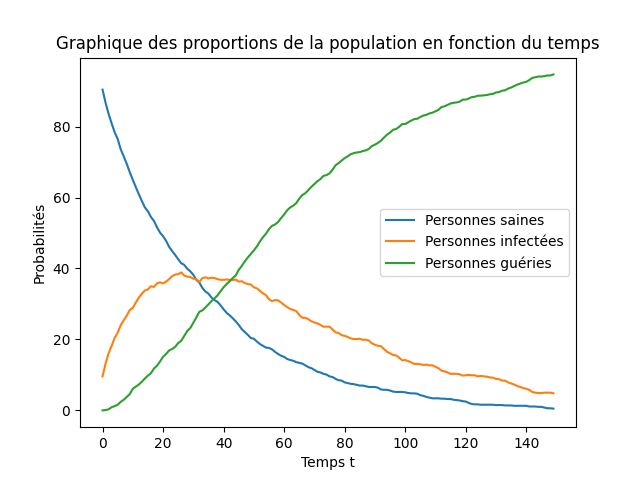

In [37]:
affiche_graphe_multi(liste_pourcentage_2, nom_fig="Graph_Partie2_8_2.png")
Image(filename="Graph_Partie2_8_2.png")

$A = 
\begin{pmatrix}
  &    S &    I &    R \\
S & 0.60 & 0.40 &    0 \\
I &    0 & 0.60 & 0.40 \\
R &    0 &    0 &    1 \\
\end{pmatrix}
$

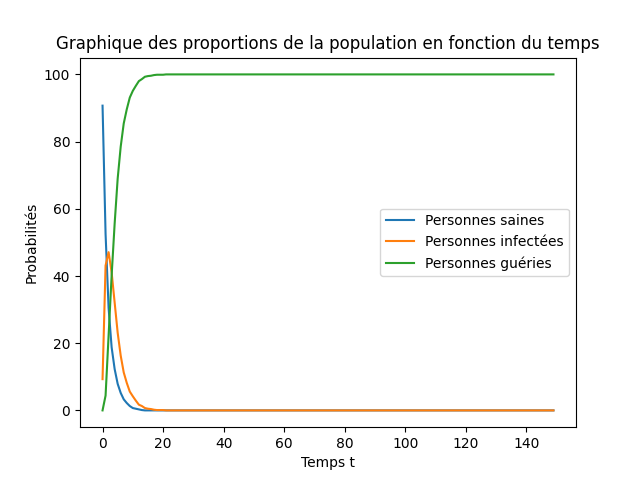

In [38]:
affiche_graphe_multi(liste_pourcentage_3, nom_fig="Graph_Partie2_8_3.png")
Image(filename="Graph_Partie2_8_3.png")

<pr>
Nous observons que la matrice de transition (en respectant le modèle) a une grande influence sur la vitesse de convergence du modèle.<br>
En effet, lorsque les probabilités de rester sur le même état augmente, on tend plus lentement vers $π^*$.<br>
Tandis que dans le cas contraire, on tend extrêmement vite vers $π^*$.<br>
Cependant, nous remarquons bien que modifier sur les probabilités de transition (en respectant le modèle) n'a aucune influence sur la convergence du modèle (on tend toujours vers le même état stable). Pour cause, l'état guéri est le seul état absorbant du modèle.
</pr>

## III) <u>Description du second modèle</u>
<pr>Nous allons maintenant considérer un second modèle, les individus guéris peuvent redevenir sains avec une probabilité de $0.02$. Ils-elles peuvent perdre leur immunité face à la maladie.
</pr>

### <u>Analyse du modèle</u>

<pr>

<u>**Question 1:**</u> Ce processus peut-il être modélisé par une chaîne de Markov ?
</pr>

<pr>
Ce processus peut être modélisé par une chaîne de Markov. Tout d'abord, il s'agit d'un processus stochastique, à temps discret et à espace d'états discret. De plus, il possède la propriété de Markov d'ordre 1, c'est à dire que la prédiction d'un état dépendant entièrement de l'état présent et est donc indépendante des états antérieurs. 

</pr>

<pr>

<u>**Question 2:**</u>
Donnez la nouvelle matrice de transition.
</pr>

Matrice de transition du second modèle :<br>
$A = 
\begin{pmatrix}
  &    S &    I &    R \\
S & 0.92 & 0.08 &    0 \\
I &    0 & 0.93 & 0.07 \\
R & 0.02 &    0 & 0.98 \\
\end{pmatrix}
$

In [39]:
matrice_transition_modele2 = np.array([[0.92, 0.08,    0], 
                                       [   0, 0.93, 0.07], 
                                       [0.02,    0, 0.98]])

<pr>
    
<u>**Question 3:**</u> Quels est la nature des états de cette chaîne de Markov ? Est-elle périodique ? Est-elle irréductible ?
</pr>

<pr>
Tout d'abord nous remarquons que le graphe est fortement connexe. Ainsi, tous les états sont communicants et cette chaîne de Markov est irréductible. Les états sont récurrents.<br>
De plus, elle est apériodique car il y a des boucles ( des arêtes reliant deux fois le même sommet).
</pr>

<pr>
    
<u>**Question 4:**</u> Calculez la matrice $A × A$. À quoi correspond-elle ? Est elle stochastique ? Même question pour $A^3$ et $A^4$.
</pr>

<pr>
$
A^2 = 
\begin{pmatrix}
  &      S &      I &      R \\
S & 0.8464 &  0.148 & 0.0056 \\
I & 0.0014 & 0.8649 & 0.1337 \\
R &  0.038 & 0.0016 & 0.9604 \\
\end{pmatrix}
$<br><br>
Cette matrice décrit les probabilités de passer d'un état à un autre en 2 étapes. Dans chaque ligne se trouvent les probabilités de passer de l'état représenté par cette ligne aux autres états.<br>
<br><br>
$
A^3 = 
\begin{pmatrix}
  &        S &        I &        R \\
S &   0.7788 & 0.205352 & 0.191569 \\
I & 0.003962 & 0.804469 &     0.07 \\
R & 0.054168 & 0.004528 & 0.941304 \\
\end{pmatrix}
$<br><br>
Cette matrice décrit les probabilités de passer d'un état à un autre en 3 étapes.<br>
<br><br>
$
A^4 = 
\begin{pmatrix}
  &          S &          I &          R \\
S & 0.71681296 & 0.25328136 & 0.02990568 \\
I & 0.00747642 & 0.74847313 & 0.24405045 \\
R & 0.06866064 & 0.00854448 & 0.92279488 \\
\end{pmatrix}
$<br><br>
Cette matrice décrit les probabilités de passer d'un état à un autre en 4 étapes.<br>
</pr>

In [40]:
A_pow_2 = np.matmul(matrice_transition_modele2, matrice_transition_modele2)
A_pow_3 = np.matmul(A_pow_2, matrice_transition_modele2)
A_pow_4 = np.matmul(A_pow_3, matrice_transition_modele2)

print("La matrice A^2 est-elle stochastique ? :", est_stochastique(A_pow_2))
print("La matrice A^3 est-elle stochastique ? :", est_stochastique(A_pow_3))
print("La matrice A^4 est-elle stochastique ? :", est_stochastique(A_pow_4))

La matrice A^2 est-elle stochastique ? : True
La matrice A^3 est-elle stochastique ? : True
La matrice A^4 est-elle stochastique ? : True


<pr>
    
<u>**Question 5:**</u> Réalisez les nouvelles simulations. Comment la population évolue-t-elle ?
</pr>

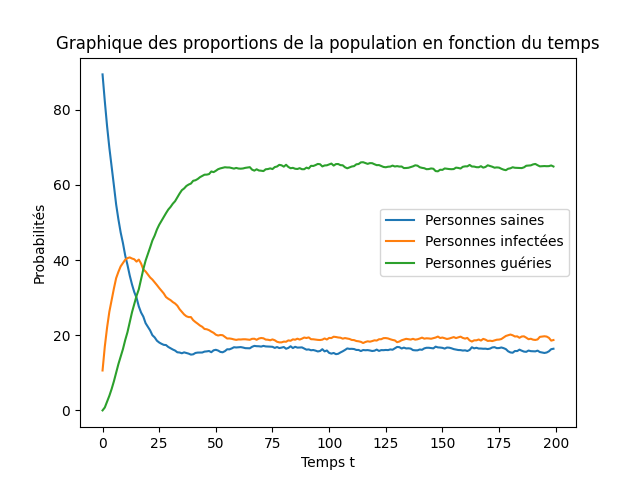

In [41]:
liste_sequence_mod2 = genere_liste_sequence(pi_0, matrice_transition_modele2, 5000, 200)
liste_pourcentage_mod2 = pourcentage_liste_sequence(liste_sequence_mod2)

affiche_graphe_multi(liste_pourcentage_mod2, nom_fig="Graph_Partie3.png")
Image(filename="Graph_Partie3.png")

<pr>
Nous remarquons que les courbes des proportions de la population se comportent de la même façon que pour le modèle 1, à la différence près qu'elles convergent vers un nouveau $π^*$.<br>
$
π^*_2 =
\begin{pmatrix}
   S &    I &    R \\
0.16 & 0.19 & 0.65 \\
\end{pmatrix}
$
</pr>

<pr>
    
<u>**Question 6:**</u> Refaites les simulations avec une autre distribution de probabilité initiale (par exemple si au temps $t = 0$, nous avons $90\%$ d’infectés et $10\%$ de sains). Explorez d’autres initialisations et comme pour chaque question commentez vos observations.
</pr>

In [42]:
pi_0_2 = [0.10, 0.90, 0]
liste_sequence_mod2_2 = genere_liste_sequence(pi_0_2, matrice_transition_modele2, 5000, 200)
liste_pourcentage_mod2_2 = pourcentage_liste_sequence(liste_sequence_mod2_2)

pi_0_3 = [0.50, 0.50, 0]
liste_sequence_mod2_3 = genere_liste_sequence(pi_0_3, matrice_transition_modele2, 5000, 200)
liste_pourcentage_mod2_3 = pourcentage_liste_sequence(liste_sequence_mod2_3)

$
π_0 =
\begin{pmatrix}
   S &    I &    R \\
0.10 & 0.90 &    0 \\
\end{pmatrix}
$

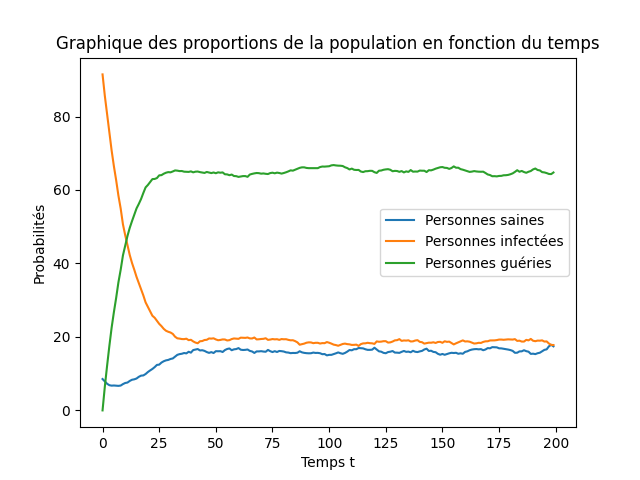

In [43]:
affiche_graphe_multi(liste_pourcentage_mod2_2, nom_fig="Graph_Partie3_2_1.png")
Image(filename="Graph_Partie3_2_1.png")

$
π_0 =
\begin{pmatrix}
   S &    I &    R \\
0.50 & 0.50 &    0 \\
\end{pmatrix}
$

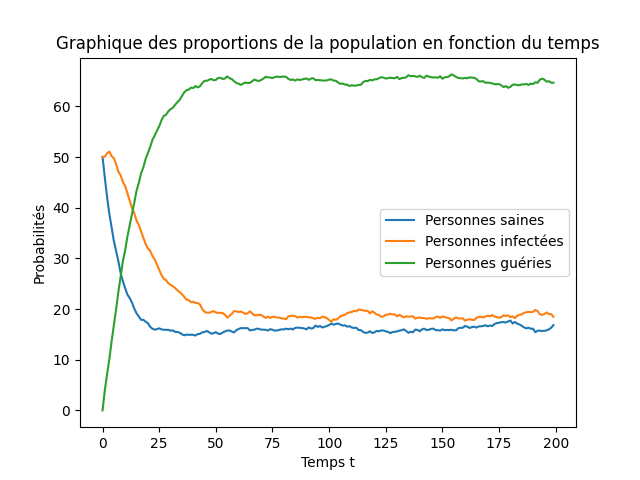

In [44]:
affiche_graphe_multi(liste_pourcentage_mod2_3, nom_fig="Graph_Partie3_2_2.png")
Image(filename="Graph_Partie3_2_2.png")

Nous remarquons que la modification de $π_0$ ne modifie rien à la convergence du modèle ni à la vitesse de convergence.<br>
La seule chose qui change est l'allure des courbes dans les 50 premières unités de temps.

<pr>
    
<u>**Question 7:**</u> Calculez la distribution de probabilité stationnaire et comparez ce résultat avec les simulations pour
$t$ assez grand.
</pr>

In [45]:
def calcul_matrice_transition_etoile(p_transition, epsilon):
    #On suppose que la chaine de Markov décrite par P converge
    p_stationnaire_n = p_transition
    p_stationnaire_n_plus_1 = np.dot(p_transition, p_transition) #A^2
    while np.any(np.absolute(p_stationnaire_n - p_stationnaire_n_plus_1) >= epsilon ):
        p_stationnaire_n = (p_stationnaire_n_plus_1)
        p_stationnaire_n_plus_1 = np.dot(p_stationnaire_n_plus_1, p_transition) 
    
    return p_stationnaire_n_plus_1

def distribution_probabilite_stationnaire(pi_0, matrice_transition) :
    p_stationnaire = calcul_matrice_transition_etoile (matrice_transition, 1e-50 )
    return np.dot(pi_0, p_stationnaire)

In [46]:
print(distribution_probabilite_stationnaire(pi_0, matrice_transition_modele2))

[0.1627907  0.18604651 0.65116279]


Le modèle 2 converge théoriquement vers : 
$
π^*_{2} = 
\begin{pmatrix}
   S &    I &    R \\
0.16 & 0.19 & 0.65 \\
\end{pmatrix}
$

### <u>Longueur de l’immunité</u>

<pr>
    
On peut se demander combien de temps un individu qui a été malade, reste protégé contre la maladie.
    
<u>**Question 1:**</u> À partir des simulations, estimez la longueur moyenne d’une séquence de $R$.
</pr>

In [47]:
def longueur_sequence(liste_sequence, categorie):
    dico_result = {}
    for sequence in liste_sequence:
        i = 0
        in_seq = False
        cpt = 0
        while i < len(sequence):
            if sequence[i] == categorie and not in_seq:
                cpt += 1
                in_seq = True
            elif sequence[i] == categorie and in_seq:
                cpt += 1
            elif sequence[i] != categorie and in_seq:
                if cpt in dico_result:
                    dico_result[cpt] += 1
                else:
                    dico_result[cpt] = 1
                cpt = 0
                in_seq = False
            if i == len(sequence)-1:
                if in_seq:
                    if cpt in dico_result:
                        dico_result[cpt] += 1
                    else:
                        dico_result[cpt] = 1
            i += 1
    return dico_result

def moyenne_dico_repart(dico_repart):
    cpt = 0
    moy = 0
    for key in dico_repart:
        moy += key * dico_repart[key]
        cpt += dico_repart[key]
    return moy/cpt

In [48]:
dico_repart_2 = longueur_sequence(liste_sequence_mod2, 2)
longueur_moyenne_immunite = moyenne_dico_repart(dico_repart_2)

print("La longueur moyenne d'une séquence de R est de", longueur_moyenne_immunite, "jours")

La longueur moyenne d'une séquence de R est de 39.05933160587336 jours


<pr>
    
<u>**Question 2:**</u> Calculez la longueur théorique d’une séquence de $R$.
</pr>

In [49]:
p = matrice_transition_modele2[2][0]
print("L'espérance de la longueur d'une séquence de R est", (1/p))
#Il faudrait ajouter la justification + pas sûr du tout du résultat

L'espérance de la longueur d'une séquence de R est 50.0


<pr>
    
<u>**Question 3:**</u> Affichez la distribution théorique et la distribution observée de la longueur de l’immunité.
</pr>

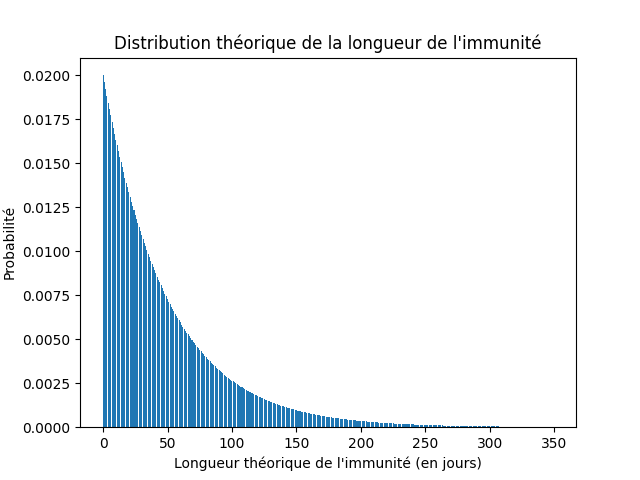

In [50]:
affiche_graphe_repartition(dico_repart_2, 2, nom_fig="Histo_Partie3.png")
Image(filename="Histo_Partie3.png")

### <u>Modifier le modèle</u>

<pr>
   
<u>**Question 1:**</u> Comment l’épidémie évolue-t-elle si vous modifiez la probabilité pour un individu sain de devenir infecté ? Quelle est la nouvelle distribution a l’équilibre ?
</pr>

In [51]:
matrice_transition_modele2_2 = np.array([[0.97, 0.03,    0], 
                                         [   0, 0.93, 0.07], 
                                         [0.02,    0, 0.98]])
matrice_transition_modele2_3 = np.array([[0.60, 0.40,    0], 
                                         [   0, 0.93, 0.07], 
                                         [0.02,    0, 0.98]])

liste_sequence_mod2_v1 = genere_liste_sequence(pi_0, matrice_transition_modele2, 5000, 200)
liste_pourcentage_mod2_v1 = pourcentage_liste_sequence(liste_sequence_mod2_v1)

liste_sequence_mod2_v2 = genere_liste_sequence(pi_0, matrice_transition_modele2_2, 5000, 200)
liste_pourcentage_mod2_v2 = pourcentage_liste_sequence(liste_sequence_mod2_v2)

liste_sequence_mod2_v3 = genere_liste_sequence(pi_0, matrice_transition_modele2_3, 5000, 200)
liste_pourcentage_mod2_v3 = pourcentage_liste_sequence(liste_sequence_mod2_v3)

$A = 
\begin{pmatrix}
  &    S &    I &    R \\
S & 0.92 & 0.08 &    0 \\
I &    0 & 0.93 & 0.07 \\
R & 0.02 &    0 & 0.98 \\
\end{pmatrix}
$

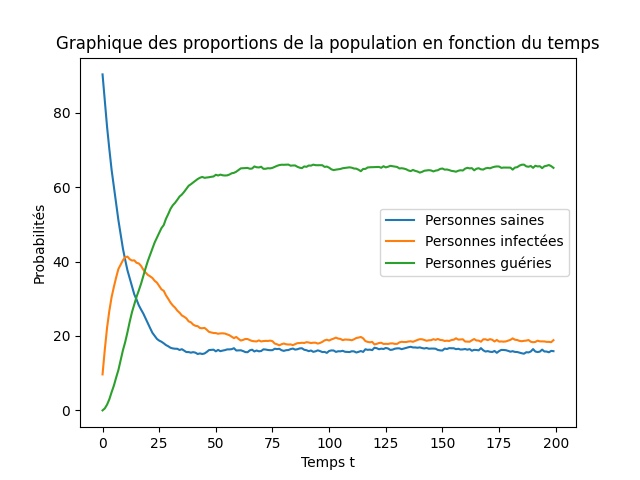

In [52]:
affiche_graphe_multi(liste_pourcentage_mod2_v1, nom_fig="Graph_Partie3_3_1.png")
Image(filename="Graph_Partie3_3_1.png")

In [53]:
print(distribution_probabilite_stationnaire(pi_0, matrice_transition_modele2))

[0.1627907  0.18604651 0.65116279]


On voit qu'à l'équilibre, on a :
$π^*_{2} = 
\begin{pmatrix}
   S &    I &    R \\
0.16 & 0.19 & 0.65 \\
\end{pmatrix}
$

$A_{2.2} = 
\begin{pmatrix}
  &    S &    I &    R \\
S & 0.97 & 0.03 &    0 \\
I &    0 & 0.93 & 0.07 \\
R & 0.02 &    0 & 0.98 \\
\end{pmatrix}
$

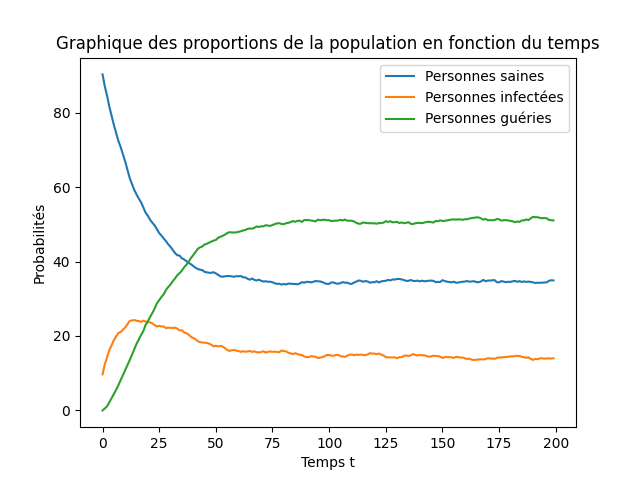

In [54]:
affiche_graphe_multi(liste_pourcentage_mod2_v2, nom_fig="Graph_Partie3_3_2.png", loc_legend="upper right")
Image(filename="Graph_Partie3_3_2.png")

In [55]:
print(distribution_probabilite_stationnaire(pi_0, matrice_transition_modele2_2))

[0.34146341 0.14634146 0.51219512]


On voit qu'à l'équilibre, on a :
$π^*_{2.2} = 
\begin{pmatrix}
   S &    I &    R \\
0.34 & 0.15 & 0.51 \\
\end{pmatrix}
$

$A_{2.3} = 
\begin{pmatrix}
  &    S &    I &    R \\
S & 0.60 & 0.40 &    0 \\
I &    0 & 0.93 & 0.07 \\
R & 0.02 &    0 & 0.98 \\
\end{pmatrix}
$

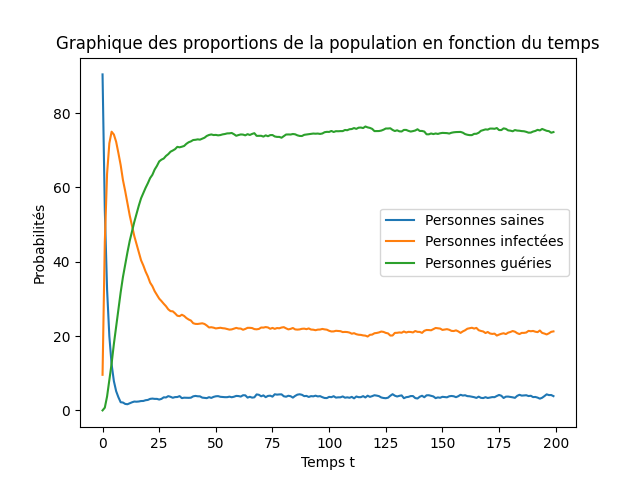

In [56]:
affiche_graphe_multi(liste_pourcentage_mod2_v3, nom_fig="Graph_Partie3_3_3.png")
Image(filename="Graph_Partie3_3_3.png")

In [57]:
print(distribution_probabilite_stationnaire(pi_0, matrice_transition_modele2_3))

[0.03743316 0.21390374 0.7486631 ]


On observe qu'à l'équilibre, on a :
$π^*_{2.3} = 
\begin{pmatrix}
   S &    I &    R \\
0.04 & 0.21 & 0.75 \\
\end{pmatrix}
$

<pr>
On remarque que changer la probabilité d'infection modifie grandement les graphes obtenus, en modifiant à la fois l'allure des courbes et la distribution à l'équilibre $π^*_2$.<br>
Il semblerait que plus la probabilité d'infection est élevée, moins la probabilité d'être sain est faible et plus la probabilité d'être immunisé est élevée.<br>
On voit une réelle différence au niveau de la proportion de personnes saines et immunisées lorsque l'on modifie la probabilité d'infection, contrairement à la proportion d'infectés qui est relativement stable.
</pr>

<pr>
    
<u>**Question 2:**</u> Même question si vous changez la probabilité pour un individu guéri de redevenir sain.
</pr>

In [58]:
matrice_transition_modele2_2 = np.array([[0.92, 0.08,    0], 
                                         [   0, 0.93, 0.07], 
                                         [0.10,    0, 0.90]])
matrice_transition_modele2_3 = np.array([[0.92, 0.08,    0], 
                                         [   0, 0.93, 0.07], 
                                         [0.40,    0, 0.60]])

liste_sequence_mod2_v1 = genere_liste_sequence(pi_0, matrice_transition_modele2, 5000, 200)
liste_pourcentage_mod2_v1 = pourcentage_liste_sequence(liste_sequence_mod2_v1)

liste_sequence_mod2_v2 = genere_liste_sequence(pi_0, matrice_transition_modele2_2, 5000, 200)
liste_pourcentage_mod2_v2 = pourcentage_liste_sequence(liste_sequence_mod2_v2)

liste_sequence_mod2_v3 = genere_liste_sequence(pi_0, matrice_transition_modele2_3, 5000, 200)
liste_pourcentage_mod2_v3 = pourcentage_liste_sequence(liste_sequence_mod2_v3)

$A = 
\begin{pmatrix}
  &    S &    I &    R \\
S & 0.92 & 0.08 &    0 \\
I &    0 & 0.93 & 0.07 \\
R & 0.02 &    0 & 0.98 \\
\end{pmatrix}
$

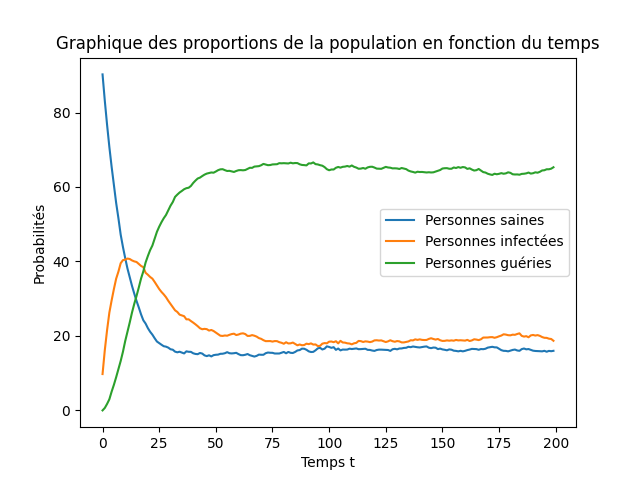

In [59]:
affiche_graphe_multi(liste_pourcentage_mod2_v1, nom_fig="Graph_Partie3_4_1.png")
Image(filename="Graph_Partie3_4_1.png")

In [60]:
print(distribution_probabilite_stationnaire(pi_0, matrice_transition_modele2))

[0.1627907  0.18604651 0.65116279]


On observe qu'à l'équilibre, on a :
$π^*_{2} = 
\begin{pmatrix}
   S &    I &    R \\
0.16 & 0.19 & 0.65 \\
\end{pmatrix}
$

$A_{2.2} = 
\begin{pmatrix}
  &    S &    I &    R \\
S & 0.92 & 0.08 &    0 \\
I &    0 & 0.93 & 0.07 \\
R & 0.10 &    0 & 0.90 \\
\end{pmatrix}
$

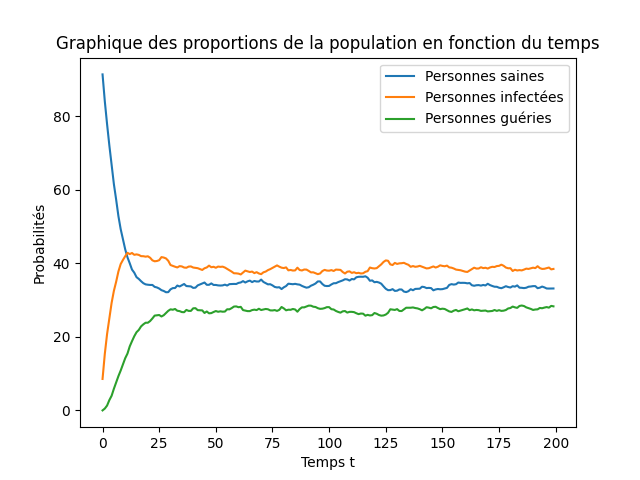

In [61]:
affiche_graphe_multi(liste_pourcentage_mod2_v2, nom_fig="Graph_Partie3_4_2.png", loc_legend="upper right")
Image(filename="Graph_Partie3_4_2.png")

In [62]:
print(distribution_probabilite_stationnaire(pi_0, matrice_transition_modele2_2))

[0.33980583 0.38834951 0.27184466]


On observe qu'à l'équilibre, on a :
$π^*_{2.2} = 
\begin{pmatrix}
   S &    I &    R \\
0.34 & 0.39 & 0.27 \\
\end{pmatrix}
$

$A_{2.3} = 
\begin{pmatrix}
  &    S &    I &    R \\
S & 0.92 & 0.08 &    0 \\
I &    0 & 0.93 & 0.07 \\
R & 0.40 &    0 & 0.60 \\
\end{pmatrix}
$

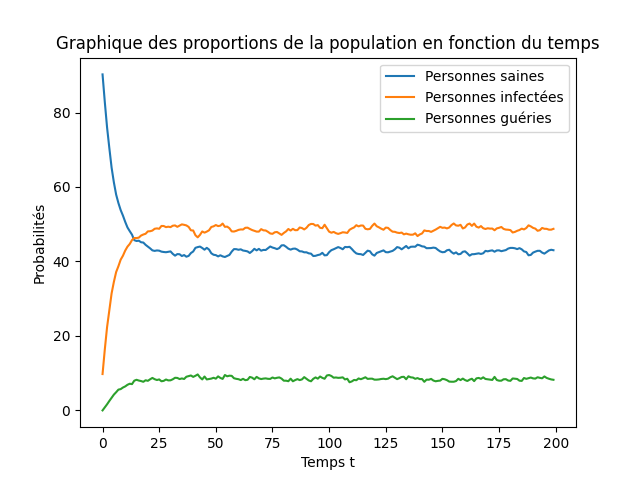

In [63]:
affiche_graphe_multi(liste_pourcentage_mod2_v3, nom_fig="Graph_Partie3_4_3.png", loc_legend="upper right")
Image(filename="Graph_Partie3_4_3.png")

In [64]:
print(distribution_probabilite_stationnaire(pi_0, matrice_transition_modele2_3))

[0.42682927 0.48780488 0.08536585]


On observe qu'à l'équilibre, on a :
$π^*_{2.3} = 
\begin{pmatrix}
   S &    I &    R \\
0.43 & 0.49 & 0.08 \\
\end{pmatrix}
$

<pr>
On remarque que changer la probabilité de perte immunitaire modifie grandement les graphes obtenus, en modifiant à la fois l'allure des courbes et la distribution à l'équilibre $π^*_2$.<br>
Il semblerait que plus la probabilité de perte immunitaire est élevée, moins la probabilité d'être immunisé est faible et plus la probabilité d'être simplement sain est élevée.<br>
On voit que moins il y a de personnes immunisées, plus le pourcentage de personnes saines et infectées sont élevées, mais ces dernières restent très proches l'une de l'autre (moins de $6\%$). On remarque juste qu'il y a légèrement plus d'infectés que de personnes saines.
</pr>

## IV) <u>Confinement</u>
<pr>On peut imaginer que si des mesures de distanciation sociale sont mises en place, la probabilité de devenir infecté devient nulle.

Nous allons alterner entre les périodes de non distanciation et de distanciation :
- En période de non-confinement, nous utilisons la matrice de transition de l’exercice précédent
- En période de confinement, la probabilité de devenir infecté pour un individu sain devient nulle

<u>**Question 1:**</u> Commencez les simulations avec la matrice de transition de l’exercice précédent.
- On peut considérer qu’au temps initial tous les individus sont sains.
- Quand il y a $25\%$ d’individus infectés dans la population, nous passons en période de distanciation. Le nombre d’individus infectés va décroître.
- Quand il y a moins de $10\%$ d’infectés, le confinement est levé.
</pr>

In [104]:
def genere_liste_sequence_confinement(pi_0, A, nb_individu, temps):
    liste_sequence = [[] for j in range(nb_individu)]
    
    Aconf = A.copy()
    Aconf[0][1] = 0
    Aconf[0][0] = 1
    
    confinement = False
    
    #on choisit l'état initial au hasard
    for indiv in range(nb_individu):
        p = rd.random()
        for i in range(len(pi_0)):
            if p < sum(pi_0[:i+1]):
                liste_sequence[indiv].append(i)
                break
    
    for t in range(1, temps):        
        somme=0
        for indiv in range(nb_individu):
            if liste_sequence[indiv][-1] == 1:
                somme += 1
        if (somme/nb_individu) >= 0.25:
            confinement = True
        elif (somme/nb_individu) < 0.10:
            confinement = False 
        
        if confinement:
            for indiv in range(nb_individu):
                p = rd.random()
                for j in range(len(Aconf)):
                    if p < sum(Aconf[liste_sequence[indiv][-1]][:j+1]):
                        liste_sequence[indiv].append(j)
                        break
        else:
            for indiv in range(nb_individu):
                p = rd.random()
                for j in range(len(A)):
                    if p < sum(A[liste_sequence[indiv][-1]][:j+1]):
                        liste_sequence[indiv].append(j)
                        break
                       
    return liste_sequence

liste_sequence_confinement = genere_liste_sequence_confinement(pi_0, matrice_transition_modele2, 5000, 200)
liste_pourcentage_confinement = pourcentage_liste_sequence(liste_sequence_confinement)

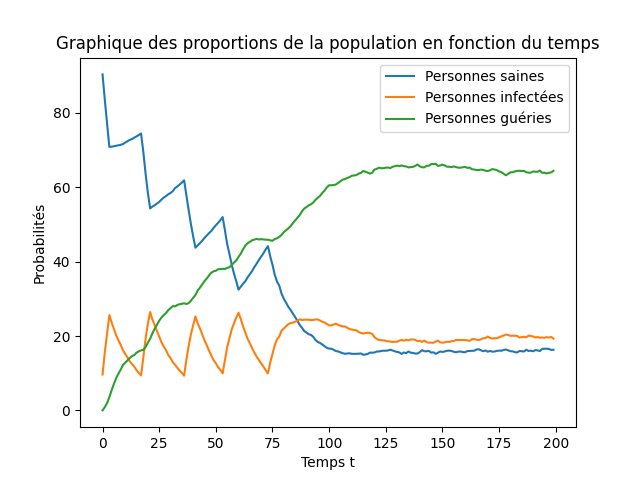

In [105]:
affiche_graphe_multi(liste_pourcentage_confinement, nom_fig="Graph_Partie4.png", loc_legend="upper right")
Image(filename="Graph_Partie4.png")

<pr>
    
<u>**Question 2:**</u> Faites les simulations pour une population assez grande, représentez l’évolution du nombre d’individus à chaque temps $t$ (vous devriez voir des “vagues”), et notez les temps de confinement et de deconfinement.
</pr>

<pr>
    
<u>**Question 3:**</u> Combien de confinements / déconfinements sont nécessaires ?
</pr>

## V) <u>Discussion</u>

<pr>

<u>**Question 1:**</u> Quelles remarques critiques pouvez faire sur les modèles utilisés ?
</pr>

<pr>
Tout d’abord, le fait qu’il n’y ait que 3 états est réducteur par rapport à la réalité. En effet, il y a généralement des individus immunisés, définitivement ou temporairement après la guérison, et un taux de mortalité lié à chaque agent infectieux. De plus, ces modèles supposent que le brassage de la population est uniforme, même dans le cas des confinements. 
</pr>

<pr>
    
<u>**Question 2:**</u> <em>(Optionnelle)</em> Proposez des améliorations et implémentez-les si possible.
</pr>